본 내용은 Doheon 님의 코드를 연습한 파일입니다. 원본 코드 및 doheon 님의 설명을 보고 싶으시다면 아래의 링크로 가주시면 됩니다.
- Original code: 
- Doheon github: https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-3.lstm-post/

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

## 서인천IC-부평IC 평균속도.csv
- 한 시간 간격의 한 달치 특정 구간의 평균 속도 데이터
- 마지막 일주일 간의 평균 속도 예측
- 744개의 관측치

(744, 2)


,집계일시,평균속도
0,2021050100,98.63
1,2021050101,100.53
2,2021050102,99.86
3,2021050103,99.34
4,2021050104,93.64


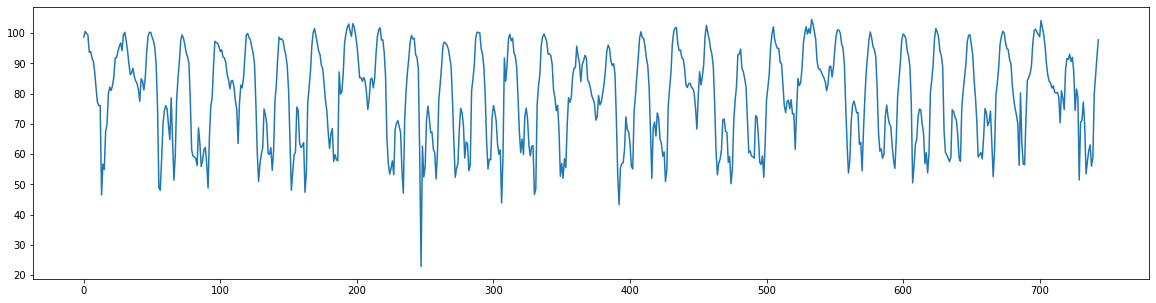

In [10]:
data = pd.read_csv("서인천IC-부평IC 평균속도.csv", encoding='CP949', index_col=0)
plt.figure(figsize=(20,5))
plt.plot(range(len(data)), data[["평균속도"]])
print(data.shape)
data.head()

In [18]:
"""훈련 데이터와 평가 데이터 분리"""
## 마지막 일주일을 평가 데이터 기간으로 설정
train = data[:-24*7].copy()
test = data[-24*7:].copy()

In [19]:
"""MinMax 정규화"""
## train으로 정규화한 파라미터로 test 정규화
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
train["평균속도"] = min_max_scaler.fit_transform(train[["평균속도"]].to_numpy().reshape(-1,1))
test['평균속도'] = min_max_scaler.transform(test[["평균속도"]].to_numpy().reshape(-1,1))

In [21]:
train = train["평균속도"].to_numpy()
test = test["평균속도"].to_numpy()
train

array([0.92784515, 0.95112091, 0.94291314, 0.93654294, 0.86671567,
       0.87014578, 0.84392993, 0.82910695, 0.78574054, 0.72105843,
       0.6644616 , 0.65074115, 0.65172118, 0.2892319 , 0.41406346,
       0.39225775, 0.54734779, 0.57491118, 0.69937523, 0.72583609,
       0.71211564, 0.73122626, 0.76760995, 0.84417494, 0.84503246,
       0.86990077, 0.89084895, 0.9045694 , 0.87296337, 0.93678795,
       0.9475683 , 0.91571726, 0.87418841, 0.82224672, 0.77618523,
       0.78304545, 0.80215607, 0.76822247, 0.7508269 , 0.74065907,
       0.71505574, 0.66813671, 0.75952468, 0.75009188, 0.71419821,
       0.76270979, 0.86304055, 0.93041774, 0.94732329, 0.94732329,
       0.92809016, 0.91338969, 0.88729634, 0.81808159, 0.64290089,
       0.31875536, 0.30834252, 0.43366409, 0.57723876, 0.62991547,
       0.65074115, 0.63726571, 0.57209359, 0.51304667, 0.68283719,
       0.50863653, 0.34901384, 0.45130467, 0.6737719 , 0.76381232,
       0.82922945, 0.91559476, 0.93678795, 0.9230675 , 0.89721

In [121]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda")
device

device(type='cuda')

# Sliding Window 설정

In [122]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [123]:
## 24시간 * 7은 일주일
## train은 그의 두 배
iw = 24*14
ow = 24*7

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

### [class] windowDataset 분해

In [124]:
## 클래스에 입력으로 들어가는 데이터 train
print(len(train))
y = train
L = train.shape[0]
print('y:', train.shape[0])

576
y: 576


In [125]:
## 다른 파라미터들
input_window=80
output_window=20
stride=1

In [126]:
## stride 씩 움직일 때 생기는 총 sample의 개수
    # 477 = (576-80-20)+1
num_samples = (L - input_window - output_window)//stride + 1
print('num_samples: ', num_samples)

num_samples:  477


In [127]:
#input과 output
X = np.zeros([input_window, num_samples])
Y = np.zeros([output_window, num_samples])
print('X.shape :', X.shape)
print('Y.shape :', Y.shape)

X.shape : (80, 477)
Y.shape : (20, 477)


In [128]:
for i in np.arange(num_samples):
    start_x = stride*i
    end_x = start_x + input_window
    X[:,i] = y[start_x:end_x] # y는 train 데이터를 의미

    start_y = stride*i + input_window
    end_y = start_y + output_window
    Y[:,i] = y[start_y:end_y]

print('X.shape :', X.shape)
print('Y.shape :', Y.shape)

X.shape : (80, 477)
Y.shape : (20, 477)


In [129]:
X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
print('X.shape :', X.shape)
print('Y.shape :', Y.shape)

X.shape : (477, 80, 1)
Y.shape : (477, 20, 1)


In [130]:
## train_loader 만들기
    # [batch_size, window_size (24*14), feature_size]
for idx, batch in enumerate(train_loader):
    print(idx)
    xx = batch[0]
    yy = batch[1]
    print('one-batch XX size :', xx.shape)
    print('one-batch YY size :', yy.shape)

0
one-batch XX size : torch.Size([64, 336, 1])
one-batch YY size : torch.Size([64, 168, 1])
1
one-batch XX size : torch.Size([9, 336, 1])
one-batch YY size : torch.Size([9, 168, 1])


In [131]:
## 연습용 xx, yy 만들기
for idx, batch in enumerate(train_loader):
    print(idx)
    xx = batch[0].to(device)
    yy = batch[1].to(device)
    print('one-batch XX size :', xx.shape)
    print('one-batch YY size :', yy.shape)
    break

0
one-batch XX size : torch.Size([64, 336, 1])
one-batch YY size : torch.Size([64, 168, 1])


# Modeling
- encoder와 decoder를 생성
    - encoder: input을 통해 decoder에 전달할 hidden_state 생성
    - decoder: input의 마지막 값과 encoder에서 받은 hidden state를 이용하여 한 개의 값을 예측
- 마지막으로 FC layer를 사용해서 input size와 동일하게 크기를 맞춘다.

In [132]:
"""일반적인 LSTM class와 별다른 차이는 없음"""
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                            num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [133]:
"""Decoder의 input으로 window의 마지막 값과 인코더의 hidden_state를 넣는다."""
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first=True)

        """input과 size를 맞추기 위해서 FC layer 사용"""
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        # 디코더 lstm의 hidden_state와 FC layer를 거쳐 input_size에 맞춘 output인 최종 결과를 함께 출력
        return output, self.hidden 


## 연습

In [134]:
batch_size = 64
target_len = 24*7
input_size = 1

## torch.zeros
print(torch.zeros(batch_size, target_len, input_size).shape)
print(torch.zeros((batch_size, target_len, input_size)).shape)

torch.Size([64, 168, 1])
torch.Size([64, 168, 1])


In [180]:
self_lstm_encoder = nn.LSTM(input_size=1, hidden_size=16, batch_first=True).to(device)
self_lstm_encoder

LSTM(1, 16, batch_first=True)

In [194]:
self_lstm_encoder

LSTM(1, 16, batch_first=True)

In [197]:
"""인코더 입력"""
## 인코더에 들어가는 입력값
    # 여기서 xx는 [batch_size, window_size, feature_size]이다.
inputs = xx.float().cuda()
print('인코더 입력값: ', inputs.shape)

self_lstm_encoder = nn.LSTM(input_size=1, hidden_size=16, batch_first=True).cuda()
en_out, en_hidden = self_lstm_encoder(inputs)
print('디코더에 입력으로 들어가는 인코더의 hidden_state:', len(en_hidden))
print('디코더에 입력으로 들어가는 인코더의 hidden_state shape:', en_hidden[0].shape) # [n_features, batch_size, hidden_state_size]

인코더 입력값:  torch.Size([64, 336, 1])
디코더에 입력으로 들어가는 인코더의 hidden_state: 2
디코더에 입력으로 들어가는 인코더의 hidden_state shape: torch.Size([1, 64, 16])


In [200]:
"""디코더 입력 준비"""
## 디코더에 들어가는 값
    # 인코더의 batch별 마지막 값 (window별 마지막 값), 인코더 hidden_state
decoder_inputs = inputs[:, -1, :].cuda()
print('디코더 입력값: ', decoder_inputs.shape)

decoder_inputs = decoder_inputs.unsqueeze(-1)
print('디코더 최종 입력값: ', decoder_inputs.shape)

디코더 입력값:  torch.Size([64, 1])
디코더 최종 입력값:  torch.Size([64, 1, 1])


In [205]:
"""디코더 입력"""
# 최종 디코더 입력값 하나
print(decoder_inputs[0])

# 디코더 입력
self_lstm_decoder = nn.LSTM(input_size=1, hidden_size=16, batch_first=True).cuda()
dec_lstm_out, dec_hidden = self_lstm_decoder(decoder_inputs, en_hidden)
print(dec_lstm_out.shape) # 디코더 output

tensor([[0.8943]], device='cuda:0')
torch.Size([64, 1, 16])


In [206]:
"""최종 예측 (Linear)"""
self_linear = nn.Linear(16, 1).cuda()
final_output = self_linear(dec_lstm_out)
print('최종 output:', final_output.shape)

최종 output: torch.Size([64, 1, 1])


-----

In [165]:
"""최종 인코더 디코더 모델"""
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        
        ## 이전에 정의한 인코더와 디코더 클래스를 정의한다.
        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0] # input : [batch_size, window_size, feature_size]
        input_size = inputs.shape[2] # feature size -> 변수의 개수대로 예측을 수행해야 함
        
        ## 최종 결과 맞춰놓기
        outputs = torch.zeros(batch_size, target_len, input_size)

        ## 인코더의 hidden_state를 저장해두어야 함
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :] # 디코더의 입력으로는 batch별 window의 마지막 값이 들어간다.
        
        """원하는 길이가 될 때까지 decoder를 실행한다. forward()는 train 시에 사용"""
        for t in range(target_len): # target_len은 예측해야 하는 길이인 24*7을 의미한다.
            out, hidden = self.decoder(decoder_input, hidden) 
            ## out : [batch, 1, 1]
            # print(out.shape)
            out =  out.squeeze(1) ## out.squeeze(1) : [batch, 1]
            if random.random() < teacher_forcing_ratio: # 디코더의 input으로 이전 예측값이 아닌 실제값을 사용하는 teacher forcing ratio
                decoder_input = targets[:, t, :] # 여기서 targets는 실제값을 의미
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [207]:
device

device(type='cuda')

In [167]:
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

In [168]:
learning_rate=0.01
epoch = 3000
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [169]:
from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        if i%10==0:
            print(f"{i} Epochs train MSE: {loss.item():1.5f}")

  0%|          | 1/3000 [00:00<22:11,  2.25it/s]

0 Epochs train MSE: 0.80761


  0%|          | 11/3000 [00:04<17:05,  2.91it/s]

10 Epochs train MSE: 0.05351


  1%|          | 21/3000 [00:07<17:08,  2.90it/s]

20 Epochs train MSE: 0.02912


  1%|          | 31/3000 [00:10<16:40,  2.97it/s]

30 Epochs train MSE: 0.02829


  1%|▏         | 41/3000 [00:14<17:13,  2.86it/s]

40 Epochs train MSE: 0.02793


  2%|▏         | 51/3000 [00:18<17:55,  2.74it/s]

50 Epochs train MSE: 0.02667


  2%|▏         | 61/3000 [00:21<18:24,  2.66it/s]

60 Epochs train MSE: 0.02494


  2%|▏         | 71/3000 [00:25<21:13,  2.30it/s]

70 Epochs train MSE: 0.02341


  3%|▎         | 81/3000 [00:29<19:30,  2.49it/s]

80 Epochs train MSE: 0.02171


  3%|▎         | 91/3000 [00:33<18:08,  2.67it/s]

90 Epochs train MSE: 0.01896


  3%|▎         | 101/3000 [00:37<17:28,  2.76it/s]

100 Epochs train MSE: 0.01533


  4%|▎         | 111/3000 [00:41<17:30,  2.75it/s]

110 Epochs train MSE: 0.01263


  4%|▍         | 121/3000 [00:44<17:57,  2.67it/s]

120 Epochs train MSE: 0.01220


  4%|▍         | 131/3000 [00:48<17:41,  2.70it/s]

130 Epochs train MSE: 0.01092


  5%|▍         | 141/3000 [00:52<17:48,  2.68it/s]

140 Epochs train MSE: 0.01180


  5%|▌         | 151/3000 [00:56<18:55,  2.51it/s]

150 Epochs train MSE: 0.01210


  5%|▌         | 161/3000 [01:00<17:59,  2.63it/s]

160 Epochs train MSE: 0.01058


  6%|▌         | 171/3000 [01:04<18:02,  2.61it/s]

170 Epochs train MSE: 0.01051


  6%|▌         | 181/3000 [01:07<18:03,  2.60it/s]

180 Epochs train MSE: 0.00804


  6%|▋         | 191/3000 [01:11<16:40,  2.81it/s]

190 Epochs train MSE: 0.01058


  7%|▋         | 201/3000 [01:15<17:15,  2.70it/s]

200 Epochs train MSE: 0.00814


  7%|▋         | 211/3000 [01:18<17:37,  2.64it/s]

210 Epochs train MSE: 0.01015


  7%|▋         | 221/3000 [01:22<17:14,  2.69it/s]

220 Epochs train MSE: 0.00854


  8%|▊         | 231/3000 [01:26<16:57,  2.72it/s]

230 Epochs train MSE: 0.00837


  8%|▊         | 241/3000 [01:29<16:21,  2.81it/s]

240 Epochs train MSE: 0.00903


  8%|▊         | 251/3000 [01:33<16:16,  2.81it/s]

250 Epochs train MSE: 0.00902


  9%|▊         | 261/3000 [01:37<16:20,  2.79it/s]

260 Epochs train MSE: 0.00774


  9%|▉         | 271/3000 [01:40<16:41,  2.72it/s]

270 Epochs train MSE: 0.00973


  9%|▉         | 281/3000 [01:44<16:14,  2.79it/s]

280 Epochs train MSE: 0.00858


 10%|▉         | 291/3000 [01:48<16:05,  2.81it/s]

290 Epochs train MSE: 0.00952


 10%|█         | 301/3000 [01:51<15:46,  2.85it/s]

300 Epochs train MSE: 0.00783


 10%|█         | 311/3000 [01:55<16:15,  2.76it/s]

310 Epochs train MSE: 0.00894


 11%|█         | 321/3000 [01:58<16:27,  2.71it/s]

320 Epochs train MSE: 0.00824


 11%|█         | 331/3000 [02:02<15:49,  2.81it/s]

330 Epochs train MSE: 0.00772


 11%|█▏        | 341/3000 [02:06<17:31,  2.53it/s]

340 Epochs train MSE: 0.00881


 12%|█▏        | 351/3000 [02:10<15:57,  2.77it/s]

350 Epochs train MSE: 0.00963


 12%|█▏        | 361/3000 [02:13<16:03,  2.74it/s]

360 Epochs train MSE: 0.00689


 12%|█▏        | 371/3000 [02:17<15:55,  2.75it/s]

370 Epochs train MSE: 0.00851


 13%|█▎        | 381/3000 [02:21<16:04,  2.72it/s]

380 Epochs train MSE: 0.00778


 13%|█▎        | 391/3000 [02:24<16:46,  2.59it/s]

390 Epochs train MSE: 0.00784


 13%|█▎        | 401/3000 [02:29<17:26,  2.48it/s]

400 Epochs train MSE: 0.00802


 14%|█▎        | 411/3000 [02:32<16:17,  2.65it/s]

410 Epochs train MSE: 0.00790


 14%|█▍        | 421/3000 [02:36<16:02,  2.68it/s]

420 Epochs train MSE: 0.00739


 14%|█▍        | 431/3000 [02:40<17:33,  2.44it/s]

430 Epochs train MSE: 0.00743


 15%|█▍        | 441/3000 [02:44<16:32,  2.58it/s]

440 Epochs train MSE: 0.00759


 15%|█▌        | 451/3000 [02:48<15:59,  2.66it/s]

450 Epochs train MSE: 0.01064


 15%|█▌        | 461/3000 [02:53<16:19,  2.59it/s]

460 Epochs train MSE: 0.00803


 16%|█▌        | 471/3000 [02:57<16:15,  2.59it/s]

470 Epochs train MSE: 0.00935


 16%|█▌        | 481/3000 [03:01<16:47,  2.50it/s]

480 Epochs train MSE: 0.00768


 16%|█▋        | 491/3000 [03:04<16:32,  2.53it/s]

490 Epochs train MSE: 0.00619


 17%|█▋        | 501/3000 [03:08<14:30,  2.87it/s]

500 Epochs train MSE: 0.00673


 17%|█▋        | 511/3000 [03:12<16:16,  2.55it/s]

510 Epochs train MSE: 0.00653


 17%|█▋        | 521/3000 [03:15<14:40,  2.82it/s]

520 Epochs train MSE: 0.00658


 18%|█▊        | 531/3000 [03:19<14:58,  2.75it/s]

530 Epochs train MSE: 0.00575


 18%|█▊        | 541/3000 [03:23<14:35,  2.81it/s]

540 Epochs train MSE: 0.00565


 18%|█▊        | 551/3000 [03:26<13:45,  2.97it/s]

550 Epochs train MSE: 0.00426


 19%|█▊        | 561/3000 [03:29<13:53,  2.93it/s]

560 Epochs train MSE: 0.00405


 19%|█▉        | 571/3000 [03:33<13:58,  2.90it/s]

570 Epochs train MSE: 0.00491


 19%|█▉        | 581/3000 [03:36<13:46,  2.93it/s]

580 Epochs train MSE: 0.00415


 20%|█▉        | 591/3000 [03:40<13:45,  2.92it/s]

590 Epochs train MSE: 0.00397


 20%|██        | 601/3000 [03:43<15:00,  2.66it/s]

600 Epochs train MSE: 0.00360


 20%|██        | 611/3000 [03:47<15:33,  2.56it/s]

610 Epochs train MSE: 0.00324


 21%|██        | 621/3000 [03:51<14:13,  2.79it/s]

620 Epochs train MSE: 0.00342


 21%|██        | 631/3000 [03:54<14:24,  2.74it/s]

630 Epochs train MSE: 0.00305


 21%|██▏       | 641/3000 [03:58<14:35,  2.69it/s]

640 Epochs train MSE: 0.00326


 22%|██▏       | 651/3000 [04:02<14:30,  2.70it/s]

650 Epochs train MSE: 0.00366


 22%|██▏       | 661/3000 [04:06<14:16,  2.73it/s]

660 Epochs train MSE: 0.00348


 22%|██▏       | 671/3000 [04:09<14:22,  2.70it/s]

670 Epochs train MSE: 0.00346


 23%|██▎       | 681/3000 [04:13<14:02,  2.75it/s]

680 Epochs train MSE: 0.00307


 23%|██▎       | 691/3000 [04:17<13:44,  2.80it/s]

690 Epochs train MSE: 0.00328


 23%|██▎       | 701/3000 [04:20<14:30,  2.64it/s]

700 Epochs train MSE: 0.00367


 24%|██▎       | 711/3000 [04:24<15:18,  2.49it/s]

710 Epochs train MSE: 0.00282


 24%|██▍       | 721/3000 [04:28<14:04,  2.70it/s]

720 Epochs train MSE: 0.00286


 24%|██▍       | 731/3000 [04:31<14:15,  2.65it/s]

730 Epochs train MSE: 0.00394


 25%|██▍       | 741/3000 [04:35<15:04,  2.50it/s]

740 Epochs train MSE: 0.00291


 25%|██▌       | 751/3000 [04:39<13:46,  2.72it/s]

750 Epochs train MSE: 0.00275


 25%|██▌       | 761/3000 [04:43<13:57,  2.67it/s]

760 Epochs train MSE: 0.00290


 26%|██▌       | 771/3000 [04:46<13:44,  2.71it/s]

770 Epochs train MSE: 0.00731


 26%|██▌       | 781/3000 [04:50<13:24,  2.76it/s]

780 Epochs train MSE: 0.00332


 26%|██▋       | 791/3000 [04:54<13:38,  2.70it/s]

790 Epochs train MSE: 0.00275


 27%|██▋       | 801/3000 [04:57<13:31,  2.71it/s]

800 Epochs train MSE: 0.00258


 27%|██▋       | 811/3000 [05:01<13:19,  2.74it/s]

810 Epochs train MSE: 0.00294


 27%|██▋       | 821/3000 [05:05<13:11,  2.75it/s]

820 Epochs train MSE: 0.00247


 28%|██▊       | 831/3000 [05:08<13:49,  2.62it/s]

830 Epochs train MSE: 0.00244


 28%|██▊       | 841/3000 [05:12<12:52,  2.79it/s]

840 Epochs train MSE: 0.00266


 28%|██▊       | 851/3000 [05:16<12:48,  2.80it/s]

850 Epochs train MSE: 0.00284


 29%|██▊       | 861/3000 [05:19<13:34,  2.63it/s]

860 Epochs train MSE: 0.00260


 29%|██▉       | 871/3000 [05:23<13:00,  2.73it/s]

870 Epochs train MSE: 0.00250


 29%|██▉       | 881/3000 [05:27<12:50,  2.75it/s]

880 Epochs train MSE: 0.00220


 30%|██▉       | 891/3000 [05:30<13:01,  2.70it/s]

890 Epochs train MSE: 0.00273


 30%|███       | 901/3000 [05:35<14:18,  2.44it/s]

900 Epochs train MSE: 0.00252


 30%|███       | 911/3000 [05:38<13:33,  2.57it/s]

910 Epochs train MSE: 0.00225


 31%|███       | 921/3000 [05:42<13:05,  2.65it/s]

920 Epochs train MSE: 0.00202


 31%|███       | 931/3000 [05:46<12:39,  2.72it/s]

930 Epochs train MSE: 0.00226


 31%|███▏      | 941/3000 [05:50<12:28,  2.75it/s]

940 Epochs train MSE: 0.00220


 32%|███▏      | 951/3000 [05:53<12:25,  2.75it/s]

950 Epochs train MSE: 0.00258


 32%|███▏      | 961/3000 [05:57<12:33,  2.71it/s]

960 Epochs train MSE: 0.00210


 32%|███▏      | 971/3000 [06:01<12:08,  2.79it/s]

970 Epochs train MSE: 0.00217


 33%|███▎      | 981/3000 [06:04<13:06,  2.57it/s]

980 Epochs train MSE: 0.00214


 33%|███▎      | 991/3000 [06:08<13:06,  2.55it/s]

990 Epochs train MSE: 0.00233


 33%|███▎      | 1001/3000 [06:12<12:21,  2.70it/s]

1000 Epochs train MSE: 0.00186


 34%|███▎      | 1011/3000 [06:16<13:18,  2.49it/s]

1010 Epochs train MSE: 0.00179


 34%|███▍      | 1021/3000 [06:20<13:26,  2.45it/s]

1020 Epochs train MSE: 0.00258


 34%|███▍      | 1031/3000 [06:25<13:04,  2.51it/s]

1030 Epochs train MSE: 0.00204


 35%|███▍      | 1041/3000 [06:29<13:37,  2.40it/s]

1040 Epochs train MSE: 0.00290


 35%|███▌      | 1051/3000 [06:33<12:32,  2.59it/s]

1050 Epochs train MSE: 0.00220


 35%|███▌      | 1061/3000 [06:37<13:01,  2.48it/s]

1060 Epochs train MSE: 0.00189


 36%|███▌      | 1071/3000 [06:40<12:13,  2.63it/s]

1070 Epochs train MSE: 0.00288


 36%|███▌      | 1081/3000 [06:44<11:44,  2.72it/s]

1080 Epochs train MSE: 0.00195


 36%|███▋      | 1091/3000 [06:48<12:52,  2.47it/s]

1090 Epochs train MSE: 0.00190


 37%|███▋      | 1101/3000 [06:52<11:48,  2.68it/s]

1100 Epochs train MSE: 0.00163


 37%|███▋      | 1111/3000 [06:56<12:30,  2.52it/s]

1110 Epochs train MSE: 0.00223


 37%|███▋      | 1121/3000 [07:00<11:30,  2.72it/s]

1120 Epochs train MSE: 0.00600


 38%|███▊      | 1131/3000 [07:03<11:55,  2.61it/s]

1130 Epochs train MSE: 0.00183


 38%|███▊      | 1141/3000 [07:07<11:39,  2.66it/s]

1140 Epochs train MSE: 0.00200


 38%|███▊      | 1151/3000 [07:11<12:07,  2.54it/s]

1150 Epochs train MSE: 0.00599


 39%|███▊      | 1161/3000 [07:14<11:01,  2.78it/s]

1160 Epochs train MSE: 0.00311


 39%|███▉      | 1171/3000 [07:18<11:01,  2.76it/s]

1170 Epochs train MSE: 0.00192


 39%|███▉      | 1181/3000 [07:22<13:13,  2.29it/s]

1180 Epochs train MSE: 0.00217


 40%|███▉      | 1191/3000 [07:26<11:56,  2.53it/s]

1190 Epochs train MSE: 0.00245


 40%|████      | 1201/3000 [07:30<11:50,  2.53it/s]

1200 Epochs train MSE: 0.00202


 40%|████      | 1211/3000 [07:34<11:22,  2.62it/s]

1210 Epochs train MSE: 0.00208


 41%|████      | 1221/3000 [07:38<12:08,  2.44it/s]

1220 Epochs train MSE: 0.00164


 41%|████      | 1231/3000 [07:42<11:04,  2.66it/s]

1230 Epochs train MSE: 0.00170


 41%|████▏     | 1241/3000 [07:46<11:00,  2.66it/s]

1240 Epochs train MSE: 0.00157


 42%|████▏     | 1251/3000 [07:50<11:31,  2.53it/s]

1250 Epochs train MSE: 0.00172


 42%|████▏     | 1261/3000 [07:54<12:05,  2.40it/s]

1260 Epochs train MSE: 0.00192


 42%|████▏     | 1271/3000 [07:58<10:56,  2.63it/s]

1270 Epochs train MSE: 0.00155


 43%|████▎     | 1281/3000 [08:01<10:20,  2.77it/s]

1280 Epochs train MSE: 0.00163


 43%|████▎     | 1291/3000 [08:05<10:25,  2.73it/s]

1290 Epochs train MSE: 0.00209


 43%|████▎     | 1301/3000 [08:09<10:28,  2.70it/s]

1300 Epochs train MSE: 0.00463


 44%|████▎     | 1311/3000 [08:13<10:10,  2.77it/s]

1310 Epochs train MSE: 0.00292


 44%|████▍     | 1321/3000 [08:16<10:31,  2.66it/s]

1320 Epochs train MSE: 0.00236


 44%|████▍     | 1331/3000 [08:20<10:10,  2.73it/s]

1330 Epochs train MSE: 0.00189


 45%|████▍     | 1341/3000 [08:24<10:48,  2.56it/s]

1340 Epochs train MSE: 0.00184


 45%|████▌     | 1351/3000 [08:28<10:50,  2.54it/s]

1350 Epochs train MSE: 0.00166


 45%|████▌     | 1361/3000 [08:32<11:11,  2.44it/s]

1360 Epochs train MSE: 0.00467


 46%|████▌     | 1371/3000 [08:36<10:40,  2.54it/s]

1370 Epochs train MSE: 0.00266


 46%|████▌     | 1381/3000 [08:40<10:44,  2.51it/s]

1380 Epochs train MSE: 0.00145


 46%|████▋     | 1391/3000 [08:44<10:16,  2.61it/s]

1390 Epochs train MSE: 0.00271


 47%|████▋     | 1401/3000 [08:48<10:06,  2.64it/s]

1400 Epochs train MSE: 0.00179


 47%|████▋     | 1411/3000 [08:51<10:02,  2.64it/s]

1410 Epochs train MSE: 0.00136


 47%|████▋     | 1421/3000 [08:55<09:25,  2.79it/s]

1420 Epochs train MSE: 0.00126


 48%|████▊     | 1431/3000 [08:59<10:13,  2.56it/s]

1430 Epochs train MSE: 0.00253


 48%|████▊     | 1441/3000 [09:03<10:01,  2.59it/s]

1440 Epochs train MSE: 0.00172


 48%|████▊     | 1451/3000 [09:07<09:44,  2.65it/s]

1450 Epochs train MSE: 0.00155


 49%|████▊     | 1461/3000 [09:11<09:55,  2.58it/s]

1460 Epochs train MSE: 0.00131


 49%|████▉     | 1471/3000 [09:14<09:49,  2.59it/s]

1470 Epochs train MSE: 0.00217


 49%|████▉     | 1481/3000 [09:18<09:31,  2.66it/s]

1480 Epochs train MSE: 0.00181


 50%|████▉     | 1491/3000 [09:22<10:23,  2.42it/s]

1490 Epochs train MSE: 0.00200


 50%|█████     | 1501/3000 [09:26<10:04,  2.48it/s]

1500 Epochs train MSE: 0.00133


 50%|█████     | 1511/3000 [09:30<09:04,  2.74it/s]

1510 Epochs train MSE: 0.00126


 51%|█████     | 1521/3000 [09:34<09:01,  2.73it/s]

1520 Epochs train MSE: 0.00118


 51%|█████     | 1531/3000 [09:38<09:19,  2.62it/s]

1530 Epochs train MSE: 0.00134


 51%|█████▏    | 1541/3000 [09:41<08:46,  2.77it/s]

1540 Epochs train MSE: 0.00141


 52%|█████▏    | 1551/3000 [09:45<09:05,  2.65it/s]

1550 Epochs train MSE: 0.00328


 52%|█████▏    | 1561/3000 [09:49<09:37,  2.49it/s]

1560 Epochs train MSE: 0.00322


 52%|█████▏    | 1571/3000 [09:53<08:44,  2.73it/s]

1570 Epochs train MSE: 0.00144


 53%|█████▎    | 1581/3000 [09:56<08:53,  2.66it/s]

1580 Epochs train MSE: 0.00147


 53%|█████▎    | 1591/3000 [10:00<08:36,  2.73it/s]

1590 Epochs train MSE: 0.00133


 53%|█████▎    | 1601/3000 [10:04<08:29,  2.75it/s]

1600 Epochs train MSE: 0.00138


 54%|█████▎    | 1611/3000 [10:08<08:39,  2.67it/s]

1610 Epochs train MSE: 0.00232


 54%|█████▍    | 1621/3000 [10:11<08:20,  2.76it/s]

1620 Epochs train MSE: 0.00155


 54%|█████▍    | 1631/3000 [10:15<08:43,  2.62it/s]

1630 Epochs train MSE: 0.00121


 55%|█████▍    | 1641/3000 [10:19<08:56,  2.53it/s]

1640 Epochs train MSE: 0.00121


 55%|█████▌    | 1651/3000 [10:23<08:00,  2.81it/s]

1650 Epochs train MSE: 0.00261


 55%|█████▌    | 1661/3000 [10:27<08:34,  2.60it/s]

1660 Epochs train MSE: 0.00157


 56%|█████▌    | 1671/3000 [10:30<08:24,  2.64it/s]

1670 Epochs train MSE: 0.00124


 56%|█████▌    | 1681/3000 [10:34<08:32,  2.57it/s]

1680 Epochs train MSE: 0.00104


 56%|█████▋    | 1691/3000 [10:38<08:41,  2.51it/s]

1690 Epochs train MSE: 0.00134


 57%|█████▋    | 1701/3000 [10:42<07:46,  2.78it/s]

1700 Epochs train MSE: 0.00129


 57%|█████▋    | 1711/3000 [10:46<07:51,  2.73it/s]

1710 Epochs train MSE: 0.00110


 57%|█████▋    | 1721/3000 [10:49<07:40,  2.78it/s]

1720 Epochs train MSE: 0.00136


 58%|█████▊    | 1731/3000 [10:53<07:31,  2.81it/s]

1730 Epochs train MSE: 0.00113


 58%|█████▊    | 1741/3000 [10:57<07:30,  2.79it/s]

1740 Epochs train MSE: 0.00106


 58%|█████▊    | 1751/3000 [11:00<07:25,  2.81it/s]

1750 Epochs train MSE: 0.00131


 59%|█████▊    | 1761/3000 [11:04<07:33,  2.73it/s]

1760 Epochs train MSE: 0.00140


 59%|█████▉    | 1771/3000 [11:08<07:15,  2.82it/s]

1770 Epochs train MSE: 0.00130


 59%|█████▉    | 1781/3000 [11:11<07:29,  2.71it/s]

1780 Epochs train MSE: 0.00136


 60%|█████▉    | 1791/3000 [11:15<07:53,  2.55it/s]

1790 Epochs train MSE: 0.00137


 60%|██████    | 1801/3000 [11:19<07:37,  2.62it/s]

1800 Epochs train MSE: 0.00099


 60%|██████    | 1811/3000 [11:23<07:43,  2.56it/s]

1810 Epochs train MSE: 0.00121


 61%|██████    | 1821/3000 [11:27<07:16,  2.70it/s]

1820 Epochs train MSE: 0.00100


 61%|██████    | 1831/3000 [11:31<07:02,  2.77it/s]

1830 Epochs train MSE: 0.00105


 61%|██████▏   | 1841/3000 [11:34<06:43,  2.87it/s]

1840 Epochs train MSE: 0.00106


 62%|██████▏   | 1851/3000 [11:38<08:24,  2.28it/s]

1850 Epochs train MSE: 0.00142


 62%|██████▏   | 1861/3000 [11:42<06:50,  2.78it/s]

1860 Epochs train MSE: 0.00114


 62%|██████▏   | 1871/3000 [11:46<07:46,  2.42it/s]

1870 Epochs train MSE: 0.00114


 63%|██████▎   | 1881/3000 [11:50<07:30,  2.48it/s]

1880 Epochs train MSE: 0.00126


 63%|██████▎   | 1891/3000 [11:54<08:04,  2.29it/s]

1890 Epochs train MSE: 0.00101


 63%|██████▎   | 1901/3000 [11:59<07:48,  2.35it/s]

1900 Epochs train MSE: 0.00104


 64%|██████▎   | 1911/3000 [12:03<08:00,  2.27it/s]

1910 Epochs train MSE: 0.00154


 64%|██████▍   | 1921/3000 [12:07<07:03,  2.55it/s]

1920 Epochs train MSE: 0.00147


 64%|██████▍   | 1931/3000 [12:11<07:11,  2.48it/s]

1930 Epochs train MSE: 0.00105


 65%|██████▍   | 1941/3000 [12:15<06:25,  2.75it/s]

1940 Epochs train MSE: 0.00274


 65%|██████▌   | 1951/3000 [12:19<06:26,  2.71it/s]

1950 Epochs train MSE: 0.00123


 65%|██████▌   | 1961/3000 [12:23<06:47,  2.55it/s]

1960 Epochs train MSE: 0.00113


 66%|██████▌   | 1971/3000 [12:27<06:21,  2.70it/s]

1970 Epochs train MSE: 0.00112


 66%|██████▌   | 1981/3000 [12:31<06:42,  2.53it/s]

1980 Epochs train MSE: 0.00127


 66%|██████▋   | 1991/3000 [12:35<06:39,  2.52it/s]

1990 Epochs train MSE: 0.00102


 67%|██████▋   | 2001/3000 [12:39<06:31,  2.55it/s]

2000 Epochs train MSE: 0.00109


 67%|██████▋   | 2011/3000 [12:42<06:11,  2.66it/s]

2010 Epochs train MSE: 0.00084


 67%|██████▋   | 2021/3000 [12:46<06:18,  2.59it/s]

2020 Epochs train MSE: 0.00100


 68%|██████▊   | 2031/3000 [12:50<05:53,  2.74it/s]

2030 Epochs train MSE: 0.00267


 68%|██████▊   | 2041/3000 [12:54<05:55,  2.70it/s]

2040 Epochs train MSE: 0.00133


 68%|██████▊   | 2051/3000 [12:57<05:41,  2.78it/s]

2050 Epochs train MSE: 0.00125


 69%|██████▊   | 2061/3000 [13:01<05:47,  2.70it/s]

2060 Epochs train MSE: 0.00158


 69%|██████▉   | 2071/3000 [13:05<05:37,  2.76it/s]

2070 Epochs train MSE: 0.00092


 69%|██████▉   | 2081/3000 [13:08<05:26,  2.82it/s]

2080 Epochs train MSE: 0.00116


 70%|██████▉   | 2091/3000 [13:12<05:56,  2.55it/s]

2090 Epochs train MSE: 0.00138


 70%|███████   | 2101/3000 [13:16<05:40,  2.64it/s]

2100 Epochs train MSE: 0.00144


 70%|███████   | 2111/3000 [13:21<06:45,  2.19it/s]

2110 Epochs train MSE: 0.00138


 71%|███████   | 2121/3000 [13:25<05:53,  2.49it/s]

2120 Epochs train MSE: 0.00085


 71%|███████   | 2131/3000 [13:29<05:54,  2.45it/s]

2130 Epochs train MSE: 0.00176


 71%|███████▏  | 2141/3000 [13:33<06:03,  2.37it/s]

2140 Epochs train MSE: 0.00149


 72%|███████▏  | 2151/3000 [13:37<05:24,  2.62it/s]

2150 Epochs train MSE: 0.00126


 72%|███████▏  | 2161/3000 [13:40<05:27,  2.56it/s]

2160 Epochs train MSE: 0.00090


 72%|███████▏  | 2171/3000 [13:45<05:42,  2.42it/s]

2170 Epochs train MSE: 0.00085


 73%|███████▎  | 2181/3000 [13:49<05:27,  2.50it/s]

2180 Epochs train MSE: 0.00102


 73%|███████▎  | 2191/3000 [13:53<04:55,  2.74it/s]

2190 Epochs train MSE: 0.00085


 73%|███████▎  | 2201/3000 [13:56<04:55,  2.71it/s]

2200 Epochs train MSE: 0.00172


 74%|███████▎  | 2211/3000 [14:00<04:51,  2.70it/s]

2210 Epochs train MSE: 0.00106


 74%|███████▍  | 2221/3000 [14:04<04:53,  2.66it/s]

2220 Epochs train MSE: 0.00093


 74%|███████▍  | 2231/3000 [14:07<05:02,  2.55it/s]

2230 Epochs train MSE: 0.00086


 75%|███████▍  | 2241/3000 [14:11<04:49,  2.62it/s]

2240 Epochs train MSE: 0.00104


 75%|███████▌  | 2251/3000 [14:15<04:54,  2.54it/s]

2250 Epochs train MSE: 0.00186


 75%|███████▌  | 2261/3000 [14:19<04:33,  2.70it/s]

2260 Epochs train MSE: 0.00093


 76%|███████▌  | 2271/3000 [14:23<05:05,  2.39it/s]

2270 Epochs train MSE: 0.00098


 76%|███████▌  | 2281/3000 [14:27<04:45,  2.52it/s]

2280 Epochs train MSE: 0.00083


 76%|███████▋  | 2291/3000 [14:31<04:41,  2.52it/s]

2290 Epochs train MSE: 0.00490


 77%|███████▋  | 2301/3000 [14:35<04:44,  2.46it/s]

2300 Epochs train MSE: 0.00193


 77%|███████▋  | 2311/3000 [14:39<04:38,  2.48it/s]

2310 Epochs train MSE: 0.00141


 77%|███████▋  | 2321/3000 [14:43<04:13,  2.68it/s]

2320 Epochs train MSE: 0.00104


 78%|███████▊  | 2331/3000 [14:47<04:10,  2.67it/s]

2330 Epochs train MSE: 0.00085


 78%|███████▊  | 2341/3000 [14:51<04:15,  2.58it/s]

2340 Epochs train MSE: 0.00078


 78%|███████▊  | 2351/3000 [14:55<04:52,  2.22it/s]

2350 Epochs train MSE: 0.00120


 79%|███████▊  | 2361/3000 [14:59<04:08,  2.57it/s]

2360 Epochs train MSE: 0.00086


 79%|███████▉  | 2371/3000 [15:03<04:47,  2.19it/s]

2370 Epochs train MSE: 0.00077


 79%|███████▉  | 2381/3000 [15:07<04:10,  2.47it/s]

2380 Epochs train MSE: 0.00111


 80%|███████▉  | 2391/3000 [15:11<03:58,  2.55it/s]

2390 Epochs train MSE: 0.00091


 80%|████████  | 2401/3000 [15:15<03:49,  2.61it/s]

2400 Epochs train MSE: 0.00109


 80%|████████  | 2411/3000 [15:19<03:46,  2.61it/s]

2410 Epochs train MSE: 0.00136


 81%|████████  | 2421/3000 [15:22<03:22,  2.86it/s]

2420 Epochs train MSE: 0.00083


 81%|████████  | 2431/3000 [15:26<03:37,  2.62it/s]

2430 Epochs train MSE: 0.00089


 81%|████████▏ | 2441/3000 [15:30<03:53,  2.40it/s]

2440 Epochs train MSE: 0.00202


 82%|████████▏ | 2451/3000 [15:34<03:30,  2.61it/s]

2450 Epochs train MSE: 0.00096


 82%|████████▏ | 2461/3000 [15:38<03:09,  2.85it/s]

2460 Epochs train MSE: 0.00085


 82%|████████▏ | 2471/3000 [15:41<03:09,  2.79it/s]

2470 Epochs train MSE: 0.00090


 83%|████████▎ | 2481/3000 [15:45<02:53,  2.99it/s]

2480 Epochs train MSE: 0.00109


 83%|████████▎ | 2491/3000 [15:48<02:46,  3.05it/s]

2490 Epochs train MSE: 0.00077


 83%|████████▎ | 2501/3000 [15:52<03:02,  2.73it/s]

2500 Epochs train MSE: 0.00074


 84%|████████▎ | 2511/3000 [15:55<02:49,  2.88it/s]

2510 Epochs train MSE: 0.00083


 84%|████████▍ | 2521/3000 [15:59<02:49,  2.83it/s]

2520 Epochs train MSE: 0.00071


 84%|████████▍ | 2531/3000 [16:02<02:38,  2.96it/s]

2530 Epochs train MSE: 0.00127


 85%|████████▍ | 2541/3000 [16:06<02:47,  2.73it/s]

2540 Epochs train MSE: 0.00087


 85%|████████▌ | 2551/3000 [16:09<02:44,  2.73it/s]

2550 Epochs train MSE: 0.00099


 85%|████████▌ | 2561/3000 [16:13<02:36,  2.80it/s]

2560 Epochs train MSE: 0.00085


 86%|████████▌ | 2571/3000 [16:16<02:30,  2.85it/s]

2570 Epochs train MSE: 0.00062


 86%|████████▌ | 2581/3000 [16:20<02:30,  2.78it/s]

2580 Epochs train MSE: 0.00058


 86%|████████▋ | 2591/3000 [16:24<02:38,  2.59it/s]

2590 Epochs train MSE: 0.00057


 87%|████████▋ | 2601/3000 [16:27<02:28,  2.69it/s]

2600 Epochs train MSE: 0.00056


 87%|████████▋ | 2611/3000 [16:31<02:25,  2.67it/s]

2610 Epochs train MSE: 0.00083


 87%|████████▋ | 2621/3000 [16:35<02:35,  2.44it/s]

2620 Epochs train MSE: 0.00064


 88%|████████▊ | 2631/3000 [16:39<02:23,  2.57it/s]

2630 Epochs train MSE: 0.00091


 88%|████████▊ | 2641/3000 [16:43<02:28,  2.42it/s]

2640 Epochs train MSE: 0.00068


 88%|████████▊ | 2651/3000 [16:47<02:11,  2.66it/s]

2650 Epochs train MSE: 0.00071


 89%|████████▊ | 2661/3000 [16:51<02:16,  2.49it/s]

2660 Epochs train MSE: 0.00070


 89%|████████▉ | 2671/3000 [16:55<02:10,  2.53it/s]

2670 Epochs train MSE: 0.00054


 89%|████████▉ | 2681/3000 [16:59<02:06,  2.53it/s]

2680 Epochs train MSE: 0.00052


 90%|████████▉ | 2691/3000 [17:03<02:01,  2.54it/s]

2690 Epochs train MSE: 0.00052


 90%|█████████ | 2701/3000 [17:06<01:57,  2.55it/s]

2700 Epochs train MSE: 0.00048


 90%|█████████ | 2711/3000 [17:10<01:49,  2.64it/s]

2710 Epochs train MSE: 0.00120


 91%|█████████ | 2721/3000 [17:14<01:42,  2.72it/s]

2720 Epochs train MSE: 0.00068


 91%|█████████ | 2731/3000 [17:18<01:41,  2.64it/s]

2730 Epochs train MSE: 0.00054


 91%|█████████▏| 2741/3000 [17:22<01:43,  2.49it/s]

2740 Epochs train MSE: 0.00064


 92%|█████████▏| 2751/3000 [17:26<01:34,  2.63it/s]

2750 Epochs train MSE: 0.00091


 92%|█████████▏| 2761/3000 [17:30<01:46,  2.25it/s]

2760 Epochs train MSE: 0.00080


 92%|█████████▏| 2771/3000 [17:34<01:32,  2.47it/s]

2770 Epochs train MSE: 0.00094


 93%|█████████▎| 2781/3000 [17:38<01:24,  2.61it/s]

2780 Epochs train MSE: 0.00100


 93%|█████████▎| 2791/3000 [17:42<01:17,  2.68it/s]

2790 Epochs train MSE: 0.00113


 93%|█████████▎| 2801/3000 [17:45<01:09,  2.86it/s]

2800 Epochs train MSE: 0.00339


 94%|█████████▎| 2811/3000 [17:49<01:11,  2.63it/s]

2810 Epochs train MSE: 0.00146


 94%|█████████▍| 2821/3000 [17:53<01:11,  2.51it/s]

2820 Epochs train MSE: 0.00072


 94%|█████████▍| 2831/3000 [17:57<01:00,  2.78it/s]

2830 Epochs train MSE: 0.00068


 95%|█████████▍| 2841/3000 [18:01<01:06,  2.37it/s]

2840 Epochs train MSE: 0.00048


 95%|█████████▌| 2851/3000 [18:05<00:57,  2.58it/s]

2850 Epochs train MSE: 0.00067


 95%|█████████▌| 2861/3000 [18:09<00:49,  2.79it/s]

2860 Epochs train MSE: 0.00099


 96%|█████████▌| 2871/3000 [18:12<00:46,  2.79it/s]

2870 Epochs train MSE: 0.00054


 96%|█████████▌| 2881/3000 [18:17<00:52,  2.26it/s]

2880 Epochs train MSE: 0.00062


 96%|█████████▋| 2891/3000 [18:21<00:45,  2.37it/s]

2890 Epochs train MSE: 0.00049


 97%|█████████▋| 2901/3000 [18:25<00:41,  2.37it/s]

2900 Epochs train MSE: 0.00061


 97%|█████████▋| 2911/3000 [18:29<00:35,  2.49it/s]

2910 Epochs train MSE: 0.00042


 97%|█████████▋| 2921/3000 [18:33<00:28,  2.77it/s]

2920 Epochs train MSE: 0.00113


 98%|█████████▊| 2931/3000 [18:36<00:25,  2.75it/s]

2930 Epochs train MSE: 0.00042


 98%|█████████▊| 2941/3000 [18:40<00:20,  2.85it/s]

2940 Epochs train MSE: 0.00120


 98%|█████████▊| 2951/3000 [18:43<00:17,  2.77it/s]

2950 Epochs train MSE: 0.00047


 99%|█████████▊| 2961/3000 [18:47<00:14,  2.68it/s]

2960 Epochs train MSE: 0.00043


 99%|█████████▉| 2971/3000 [18:51<00:10,  2.66it/s]

2970 Epochs train MSE: 0.00056


 99%|█████████▉| 2981/3000 [18:54<00:06,  2.84it/s]

2980 Epochs train MSE: 0.00053


100%|█████████▉| 2991/3000 [18:58<00:03,  2.96it/s]

2990 Epochs train MSE: 0.00062


100%|██████████| 3000/3000 [19:01<00:00,  2.63it/s]


In [210]:
## 학습된 모델 저장
torch.save(model, './' + 'LSTM_enc_dec_forecast.pt') 
model=torch.load('LSTM_enc_dec_forecast.pt')

In [208]:
"""연습 삼아 test"""
predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

## train_dataset은 (입력값, 실제값)과 같은 형태로 되어있기에 [0][0]이 입력값이고, [0][1]이 실제값이다.
print('연습용 입력값: ', train_dataset[0][0].shape)
print('연습용 실제값: ', train_dataset[0][1].shape)


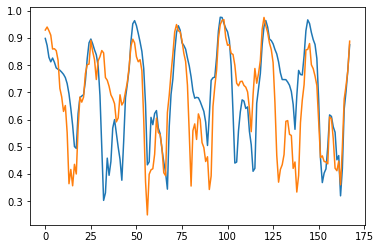

In [209]:
plt.plot(predict)
plt.plot(real)

In [217]:
"""실제 test 기간 예측"""
predict = model.predict(torch.tensor(train[-24*7*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["평균속도"].to_numpy()

## 정규화 해제
predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real = min_max_scaler.inverse_transform(real.reshape(-1,1))


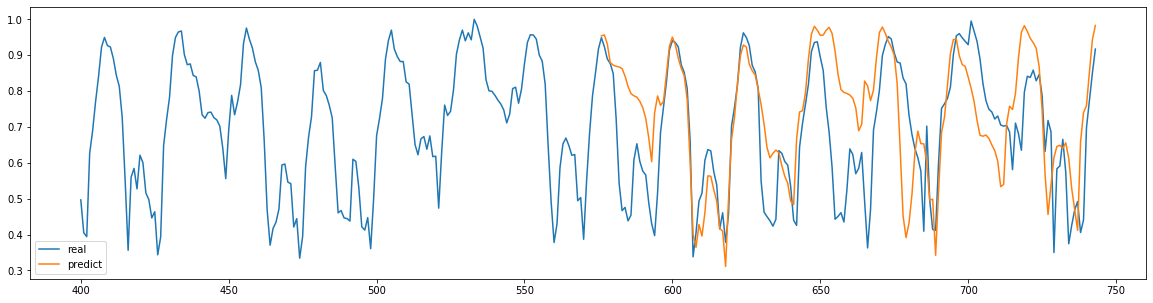

In [220]:
plt.figure(figsize=(20,5))
plt.plot(range(400,744), real[400:], label="real") # test 기간만 잘라서 사용
plt.plot(range(744-24*7,744), predict[-24*7:], label="predict")

plt.legend()
plt.show()

In [38]:
def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
MAPEval(predict[-24*7:],real[-24*7:])

8.985569589218596

In [31]:
torch.save(model.state_dict(), "model.pth")